%pip install xdart

In [1]:
%matplotlib widget

# Standard imports
import sys, os, glob, re
from pathlib import Path
import copy
from collections import OrderedDict
import dateutil.parser as dparser

# Plotting and processing
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.ticker import *
from mpl_toolkits.axes_grid1 import make_axes_locatable

# xdart imports
import xdart
from xdart.modules.ewald import get_1D_data

# Fitting 
from lmfit import Model, Parameters
from lmfit.models import LinearModel, GaussianModel, PseudoVoigtModel, SplitLorentzianModel, LorentzianModel
from xdart.utils.lmfit_models import LorentzianSquaredModel

# Parallel Processing
from joblib import Parallel, delayed
import multiprocessing, time
import pickle

# inline plotting
from ipywidgets import *
np.seterr(divide='ignore', invalid='ignore')
plt.rcParams['figure.max_open_warning'] = 100
from IPython.display import display
plt.style.use(('seaborn', 'https://raw.githubusercontent.com/vivekthampy/mpl_style/main/mpl_style.txt'))

# Finding peaks
from scipy.signal import find_peaks, find_peaks_cwt

AA = '\mathrm{\AA}^{-1}'

/var/folders/9l/vbjc09jd3h3ff94l98blbtrs6gdf5h/T/ipykernel_8051/2450958473.py:38: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(('seaborn', 'https://raw.githubusercontent.com/vivekthampy/mpl_style/main/mpl_style.txt'))


# Functions 

In [2]:
def get_normChannel(normChannel, scan_data):
    """Check to see if normalization channel exists in metadata and return name"""
    try:
        scan_data_keys = scan_data.columns
    except AttributeError:
        scan_data_keys = list(scan_data.keys())
        
    if not normChannel:
        return normChannel

    if normChannel == 'sec':
        normChannel = {'sec', 'seconds', 'Seconds', 'Sec', 'SECONDS', 'SEC'}
    else:
        normChannel = {normChannel, normChannel.lower(), normChannel.upper()}

    normChannel = normChannel.intersection(scan_data_keys)
    normChannel = normChannel.pop() if len(normChannel) > 0 else None
    
    if not normChannel:
        return None
    
    norm_fac = scan_data[normChannel].to_numpy()
    norm_fac_sum = norm_fac.sum()
    if norm_fac.sum() == 0:
        return None
        
    return normChannel


def get_norm_fac(normChannel, scan_data, idxs=None, return_sum=True):
    """Check to see if normalization channel exists in metadata and return name"""
    normChannel = get_normChannel(normChannel, scan_data)
    if not normChannel:
        return 1
    
    # arch_ids = scan_data.index if arch_ids is None else arch_ids
    idxs = range(len(scan_data.index)) if idxs is None else idxs
    norm_fac = scan_data[normChannel].iloc[idxs].to_numpy()

    norm_fac_sum = norm_fac.sum()
    if norm_fac_sum == 0:
        return 1
    
    if return_sum and not isinstance(norm_fac, int):
        norm_fac = norm_fac_sum

    return norm_fac


def get_normalized_int(i_q, normChannel, scan_data, idxs=None, return_sum=True):
    norm_fac = get_norm_fac(normChannel, scan_data, idxs, return_sum)
    try:
        i_q /= norm_fac
    except ValueError:
        i_q /= norm_fac[:,np.newaxis]
    
    return i_q

def get_iq(df, idxs=None, normChannel=None, q_range=None, return_sum=False):
    i_q = np.asarray(df['intensity'].to_list())
    q = np.asarray(df['q'].to_list())
    if idxs is not None:
        i_q, q = i_q[idxs], q[idxs]
        
    #print(arch_ids, i_q.shape)
    i_q = get_normalized_int(i_q, normChannel, df, idxs, return_sum)

    if q_range is not None:
        if q.ndim == 2:
            inds = ((q[0] >= q_range[0]) & (q[0] <= q_range[1]))
            if inds.sum() == 0:
                return None, None
            i_q, q = i_q[:,inds], q[:,inds]
        else:
            inds = ((q >= q_range[0]) & (q <= q_range[1]))
            if inds.sum() == 0:
                return None, None
            i_q, q = i_q[inds], q[inds]
            
    return q, i_q

def get_q_range(df):
    q = np.asarray(df['q'].to_list())
    if q.ndim > 1:
        q_range = (q[0][0], q[0][-1])
    else:
        q_range = (q[0], q[-1])

    return q_range

In [3]:
from xdart.modules.ewald import EwaldSphere, EwaldArch
from xdart import utils

def get_1D_data(h5_file, arch_ids=None, static=True):
    """Loads 1D data from hdf5 file

    args:
        h5_file: hdf5 file with processed data
        arch_ids: arches whose 1D data is loaded
        static: scan type flag

    returns:
        df: Pandas dataframe with integrated 1D data
    """
    h5_file = Path(h5_file)
    scan_name = h5_file.stem
    sphere = EwaldSphere(scan_name, data_file=str(h5_file), static=static)
    sphere.load_from_h5(replace=False, mode='r')

    with utils.catch_h5py_file(sphere.data_file, 'r') as file:
        if arch_ids is None:
            arch_ids = sphere.arches.index

        idxs, intensity, tth, q = [], [], [], []
        for idx in arch_ids:
            try:
                arch = EwaldArch(idx=idx, static=sphere.static, gi=sphere.gi)
                if str(idx) not in file['arches']:
                    print("No data can be found")
                    continue
                grp = file['arches'][str(idx)]
                if 'type' in grp.attrs:
                    if grp.attrs['type'] == 'EwaldArch':
                        lst_attr = [
                            "scan_info", "ai_args",
                            "gi", "static", "poni_dict"
                        ]
                        utils.h5_to_attributes(arch, grp, lst_attr)
                        arch.int_1d.from_hdf5(grp['int_1d'])
                        
                idxs.append(idx)
                intensity.append(list(arch.int_1d.norm))
                tth.append(list(arch.int_1d.ttheta))
                q.append(list(arch.int_1d.q))

            except KeyError:
                pass

    df1 = pd.DataFrame({
        'idx': idxs,
        'intensity': intensity,
        'tth': tth,
        'q': q
    })
            
    df1.set_index(df1['idx'], inplace=True)
    df2 = sphere.scan_data
    df2.rename_axis('idx')

    try:
        df = pd.concat([df1, df2.loc[df1.index]], axis=1, join='outer')
    except KeyError:
        df = df1
    
    #return df1.set_index(df1['idx'])    
    return df.set_index(df['idx'])

# Paths 

In [4]:
path = Path('/Users/vthampy/SSRL_Data/Molleigh')
fit_data_path = path

h5_files = path.glob('*.hdf5')
scans_dict = {f.stem:f for f in list(h5_files)[0:4]}
scans_dict

{'PNb9O25_17H_20C_10exp_2mmrock_4': PosixPath('/Users/vthampy/SSRL_Data/Molleigh/PNb9O25_17H_20C_10exp_2mmrock_4.hdf5')}

# Get 1D XRD Data into Dictionary/Pandas DataFrame 

In [5]:
all_data = OrderedDict({scan:get_1D_data(file) for (scan, file) in scans_dict.items()})
#all_data = OrderedDict({scan:scan_data for (scan, scan_data) in all_data.items() if (20 > len(scan_data.index)> 5) or len(scan_data.index)==1})

scans = list(all_data.keys())
scans

['PNb9O25_17H_20C_10exp_2mmrock_4']

# Widgets 

In [6]:
scan = scans[0]
df = all_data[scan]
q_range = get_q_range(df)
             
scan_widget = Dropdown(options=scans, value=scan)
npts_widget = IntSlider(min=0, max=len(df.index)-1, value=0, description='Image Number')
xlim_widget = FloatRangeSlider(min=q_range[0], max=q_range[1], value=q_range, step=0.1)
normChannel_widget = Dropdown(options=['None', 'sec', 'I0', 'bstop', 'I1', 'Monitor'], value='None', description='Normalize')
yoffset_widget = IntSlider(min=0, max=100, value=2, description='Y Offset')

def set_scan_pars(change):
    df = all_data[change.new]
    q_range = get_q_range(df)
    xlim_widget.min, xlim_widget.max = q_range
    xlim_widget.value = q_range

    npts_widget.max = len(df.index)-1
    npts_widget.value = 0

scan_widget.observe(set_scan_pars, names='value')

# Plot Waterfall

interactive(children=(Dropdown(description='scan', options=('PNb9O25_17H_20C_10exp_2mmrock_4',), value='PNb9O2…

Canvas(toolbar=None)
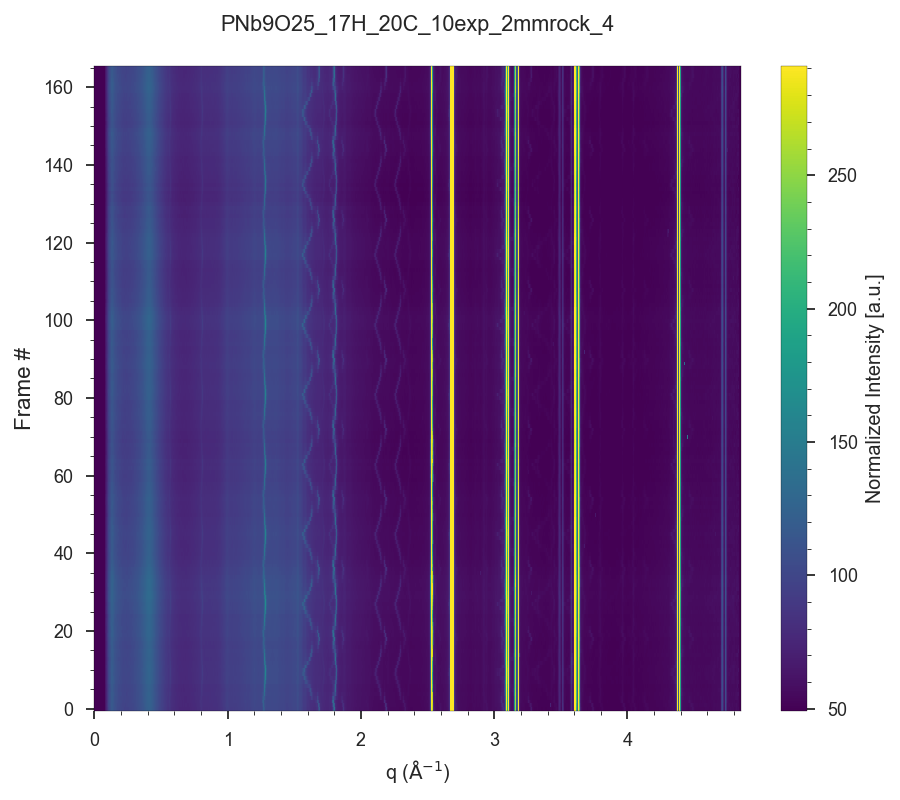

In [7]:
f1, f1_ax1 = plt.subplots(ncols=1, figsize=(9, 8))
divider = make_axes_locatable(f1_ax1)
f1_cax1 = divider.append_axes('right', size='4%', pad=0.4)

@interact(scan=scan_widget,
          xlim=xlim_widget,
          normChannel=normChannel_widget,          
          minmax=FloatRangeSlider(min=0, max=100, step=0.5, value=(5,98)),
          log=False
         )
def show_iq(scan, xlim, normChannel, minmax, log):
    [ax.cla() for ax in f1.get_axes()]
    
    # Get dataframe for scan
    df = all_data[scan]
    normChannel = get_normChannel(normChannel, df)
    normLabel = f' / {normChannel}' if normChannel else ''
    
    # Convert column data to numpy arrays
    q, i_q = get_iq(df, idxs=None, normChannel=normChannel, q_range=xlim, return_sum=False)
    if i_q.shape[0] > 1:
        # Get y-axis data (Change this to electrochemistry data)
        y_data = np.tile(np.arange(i_q.shape[0]), [i_q.shape[1], 1]).T

        # Plot waterfall if num
        if log:
            i_q = np.log(i_q.copy())
        vminmax = np.nanpercentile(i_q, minmax)
        mesh = f1_ax1.pcolormesh(q, y_data, i_q, cmap='viridis',
                   vmin=vminmax[0], vmax=vminmax[1], snap=False
                   )
        f1_ax1.set_ylabel('Frame #', fontsize=16)  # Change label here
        cb1 = plt.colorbar(mesh, cax=f1_cax1, use_gridspec=True)
        cb1.set_label(f'Normalized Intensity [a.u.]')
    else:
        f1_ax1.plot(q[0], i_q[0], 'o-')
        f1_ax1.set_ylabel(f'Normalized Intensity [a.u.]')
    
    f1_ax1.set_title(f"{scan}", pad = 25)
    f1_ax1.set_xlabel(rf'q (${AA}$)')
    f1.tight_layout()
    
    #Intensity{normLabel}

# Plot Individual 1D Intensities

In [9]:
plt.ioff()
f3, f3_ax1 = plt.subplots(ncols=1, figsize=(8, 8))
plt.ion()

scan = scans[0]
df = all_data[scan]
q_range = get_q_range(df)
             
scan_widget = Dropdown(options=scans, value=scan)
npts_widget = IntSlider(min=0, max=len(df.index)-1, value=0, description='Image Number')
xlim_widget = FloatRangeSlider(min=q_range[0], max=q_range[1], value=q_range, step=0.1)
normChannel_widget = Dropdown(options=['None', 'sec', 'I0', 'bstop', 'I1', 'Monitor'], value='None', description='Normalize')
yoffset_widget = IntSlider(min=0, max=100, value=2, description='Y Offset')

def set_scan_pars(change):
    df = all_data[change.new]
    q_range = get_q_range(df)
    xlim_widget.min, xlim_widget.max = q_range
    xlim_widget.value = q_range

    npts_widget.max = len(df.index)-1
    npts_widget.value = 0

scan_widget.observe(set_scan_pars, names='value')

yoffset_plot, normLabel, last_normChannel = 0, None, None
plotted_data = {}

@interact(scan=scan_widget,
          normChannel=normChannel_widget,          
          N=npts_widget, xlim=xlim_widget,
          log=False, overlay=False, yoffset=yoffset_widget,
         )
def show_iq(scan, normChannel, N, xlim, log, overlay, yoffset):
    global yoffset_plot, plotted_data, normLabel, last_normChannel

    f3_ax1.cla()
    if (not overlay) or (last_normChannel != normChannel):
        plotted_data.clear()
        last_normChannel = normChannel

    scan_label = scan
    label = f'{scan_label}_{N}'
    
    if label not in plotted_data.keys():
        df = all_data[scan]
        if N >= len(df.index):
            N = len(df.index) - 1
        q, i_q = get_iq(df, idxs=[N], normChannel=normChannel, q_range=xlim, return_sum=True)

        plot_label = f'{scan_label} [#{df.index[N]}]'
        if len(plot_label) > 50:
            plot_label = f'{plot_label[:20]} ... {plot_label[-20:]}'
        plotted_data[label] = (i_q, q, plot_label)
        
        normChannel = get_normChannel(normChannel, df)
        normLabel = f' / {normChannel}' if normChannel else ''
        
    yoffset_plot = 0
    for nn, (label, data) in enumerate(plotted_data.items()):
        i_q, q, plot_label = data[0].copy(), data[1].copy(), data[2]
        if overlay and (nn == 0) and (not log):
            yoffset_plot = (i_q.max()-i_q.min()) * yoffset/100.
        i_q += yoffset_plot*nn

        f3_ax1.plot(q[0], i_q[0], 'o-', label=plot_label, ms=3, lw=0.5)
        if log:
            f3_ax1.set_yscale('log')
    
    f3_ax1.set_xlabel(rf'q [${AA}$]')
    f3_ax1.set_ylabel(f'Intensity{normLabel} [a.u.]')

    if len(scan_label) > 50:
        scan_label = f'{scan_label[:20]} ... {scan_label[-20:]}'
    f3_ax1.set_title(f"{scan_label}", pad = 20)
    #f3_ax1.legend(bbox_to_anchor=(1.05, 1.0),loc='upper left')
        
    f3.tight_layout()
    f3.show()

interactive(children=(Dropdown(description='scan', options=('PNb9O25_17H_20C_10exp_2mmrock_4',), value='PNb9O2…

# Fitting 

## Fitting Functions 

In [10]:
Func_Models = {'gaussian'       : GaussianModel,
               'pvoigt'         : PseudoVoigtModel,
               'lor2'           : LorentzianSquaredModel,
               'splitlorentzian': SplitLorentzianModel,
               'lorentzian'     : LorentzianModel
              }

def get_fit(x, y, dy=None,
            q0s=None, dq0s=[0.01],
            funcs=['gaussian'],
            intercept={'value':0.0},
            slope={'value':0.0},
            sigma={'value':0.006},
            vary=True,
            **kwargs):

    if len(funcs) == 1:
        funcs = len(q0s) * funcs
        
    mod = LinearModel()
    
    if slope['value'] == 0.0:
        slope['value'] = (y[-1] - y[0])/(x[-1] - x[0])
    if intercept['value'] == 0.0:
        intercept['value'] = np.mean([y[0] - slope['value']*x[0], y[1] - slope['value']*x[1]]) 
        
    params = mod.make_params(intercept=intercept['value'], slope=slope['value'])
    y_bg = mod.eval(params, x=x)

    npeaks = [ii for ii in range(1, len(q0s)+1)]
    
    for (npeak, func) in zip(npeaks, funcs):
        mod += Func_Models[func](prefix='p{}_'.format(npeak))

    mod.set_param_hint('intercept', **intercept)
    mod.set_param_hint('slope', **slope)

    set_param_hints(mod, x, y-y_bg, npeaks, q0s, dq0s, sigma, funcs)
    
    params = mod.make_params()
    mod.missing = 'drop'
    
    fit = mod.fit(y, x=x, params=params)
    if (dy is not None) and np.sum(dy) != 0:
        fit = mod.fit(y, x=x, params=fit.params, weights=1/(dy+1e-10))
    else:
        fit = mod.fit(y, x=x, params=fit.params)
        
    return fit


def set_param_hints(mod, x, y, npeaks, q0s, dq0s, sigma, funcs):
    y0s = [max(y[ (x > (q0-0.01)) & (x < (q0+0.01)) ]) for q0 in q0s]
    amps = [y0 * sigma['value'] * np.sqrt(2*np.pi) for y0 in y0s]
    
    if len(dq0s) == 1:
        dq0s = len(q0s) * dq0s

    for i, (npeak, q0, dq0, func) in enumerate(zip(npeaks, q0s, dq0s, funcs)):
        mod.set_param_hint('p{}_sigma'.format(npeak),     **sigma) #value=sigma,   min=0.004,   max=0.01)
        mod.set_param_hint('p{}_center'.format(npeak),    value=q0,      min=q0-dq0,  max=q0+dq0)
        mod.set_param_hint('p{}_amplitude'.format(npeak), value=amps[i], min=0)
    
        if func == 'splitlorentzian':
            mod.set_param_hint('p{}_sigma_r'.format(npeak), **sigma)
        if func == 'pvoight':
            mod.set_param_hint('p{}_fraction'.format(npeak), value=0.5, min=0., max=1.)

# Functions to git fit parameters for each peak
def get_pvals(sample, phase):
    params = fit_data.FitPars[sample][phase][0].keys()
    PVals = {param:get_pval(sample, phase, param) for param in params}
        
    fit_data.All_PVals[sample][phase] = PVals
    
    
def get_pval(sample, phase, param):
    fitpars = fit_data.FitPars[sample][phase]
        
    pvals = np.asarray([fitpar[param].value  for fitpar in fitpars])
    perrs = np.asarray([fitpar[param].stderr for fitpar in fitpars])
    
    return pvals, perrs

def get_fit_raw_data(fits):
    q_all = [fit.userkws['x'] for fit in fits]
    i_q_all = [fit.data for fit in fits]
    
    x_fit = [np.linspace(q[0], q[-1], 1000) for q in q_all]
    y_fit = [fit.eval(x=x) for (x, fit) in zip(x_fit, fits)]

    print(len(x_fit), len(y_fit))
    return (q_all, i_q_all), (x_fit, y_fit)

def get_fit_data(fits):
    q_all = [fit.userkws['x'] for fit in fits]
    i_q_all = [fit.data for fit in fits]
    
    return q_all, i_q_all
    
def get_centered_iq(q, i_q, q_range, q0s=None, di_q=None):
    q0s_centered = q0s
    
    dq = q_range[1] - q_range[0]
    inds = (q > q_range[0]) & (q < q_range[1])
    
    q_max = q[inds][np.argmax(i_q[inds])]
    dq_max = q_max - np.mean(q[inds])
    
    q_range_centered = [q_max-dq/2, q_max+dq/2]
    if (q0s is None) or (len(q0s) == 1):
        q0s_centered = [q_max]

    inds = (q > q_range_centered[0]) & (q < q_range_centered[1])
    #print(f'q_max: {q_max} \nq_range: {q_range} \nq_range_centered: {q_range_centered} ')
    if di_q is not None:
        di_q = di_q[inds]
        
    #print(f'q0s: {q0s}, q0s_centered: {q0s_centered} \nq[inds]: {q[inds]}')
        
    return q[inds], i_q[inds], di_q, q0s_centered

## Fit Individual 1D Intensities

interactive(children=(Dropdown(description='scan', options=('PNb9O25_17H_20C_10exp_2mmrock_4',), value='PNb9O2…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
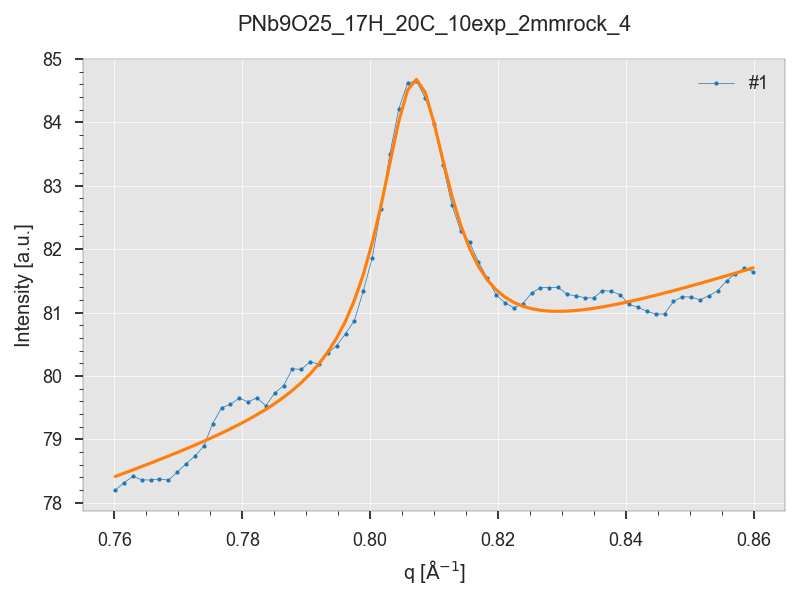

In [11]:
f3, f3_ax1 = plt.subplots(ncols=1, figsize=(8, 6))

scan = scans[0]
df = all_data[scan]
q_range = get_q_range(df)
             
scan_widget = Dropdown(options=scans, value=scan)
npts_widget = IntSlider(min=0, max=len(df.index)-1, value=0, description='Image Number')
#xlim_widget = FloatRangeSlider(min=q_range[0], max=q_range[1], value=q_range, step=0.1)
xlim_widget = FloatRangeSlider(min=q_range[0], max=q_range[1], value=(0.76,0.86), step=0.1)
normChannel_widget = Dropdown(options=['None', 'sec', 'I0', 'bstop', 'I1', 'Monitor'], value='None', description='Normalize')
yoffset_widget = IntSlider(min=0, max=100, value=2, description='Y Offset')

def set_scan_pars(change):
    df = all_data[change.new]
    q_range = get_q_range(df)
    xlim_widget.min, xlim_widget.max = q_range
    xlim_widget.value = q_range

    npts_widget.max = len(df.index)-1
    npts_widget.value = 0

scan_widget.observe(set_scan_pars, names='value')

yoffset_plot, normLabel, last_normChannel = 0, None, None
plotted_data = {}

@interact(scan=scan_widget,
          N=npts_widget,
          auto_center=False,
          q_range=xlim_widget,
          log=False, continuous_update=False
         )
def fit_iq(scan, N, auto_center, q_range, log):
    global yoffset_plot, plotted_data, normLabel, last_normChannel

    f3_ax1.cla()

    df = all_data[scan]
    if N >= len(df.index):
        N = len(df.index) - 1
    
    if auto_center:
        q, i_q = get_iq(df, idxs=[N], return_sum=True)
        q, i_q = q.squeeze(), i_q.squeeze()
        q, i_q, di_q, q0s = get_centered_iq(q, i_q, q_range, q0s=None, di_q=None)
    else:
        q, i_q = get_iq(df, idxs=[N], q_range=q_range, return_sum=True)
        q, i_q = q.squeeze(), i_q.squeeze()
        q0s = [q[np.argmax(i_q)]]
        
        
    # Fit
    fit = get_fit(
        q, i_q, dy=None,
        q0s=q0s, dq0s=[0.01],
        funcs=['pvoigt'],
        intercept={'value':0.0},
        slope={'value':0.0},
        sigma={'value':0.006},
        vary=True
    )
    y_fit = fit.eval()
    
    f3_ax1.plot(q, i_q, 'o-', label=f'#{df.index[N]}', ms=3, lw=0.5)
    f3_ax1.plot(q, y_fit)
    if log:
        f3_ax1.set_yscale('log')
        
    f3_ax1.set_xlabel(rf'q [${AA}$]')
    f3_ax1.set_ylabel(f'Intensity [a.u.]')

    scan_label = scan
    if len(scan) > 50:
        scan_label = f'{scan[:20]} ... {scan[-20:]}'
    f3_ax1.set_title(f"{scan_label}", pad = 20)
    f3_ax1.legend()
        
    f3.tight_layout()
    
    #f3_ax1.set_ylabel(f'Intensity {normLabel} [a.u.]')

In [12]:
All_Fit_Data = OrderedDict()

fit_data_files = glob.glob(os.path.join(fit_data_path, 'fit_data*.pkl'))
for f in fit_data_files:
    All_Fit_Data[os.path.basename(f)] = pickle.load(open(os.path.join(fit_data_path, f), 'rb'))

for k in All_Fit_Data.keys():
    print(k)

fit_data_1peak_pvoigt.pkl


In [13]:
Fit_Qs = {
    'PNb_110'    : dict(q0=[0.81], dq0=[0.08], q_range=(0.76, 0.86), hkl='1 1 0', phase='PNb'),
    #'Al_220'    : dict(q0=[4.35], dq0=[0.03], q_range=(4.28, 4.43), hkl='2 0 0', phase='Al'),
    #'Al_311'    : dict(q0=[5.13, 5.15], dq0=[0.01, 0.01], q_range=(5.03, 5.25), hkl='3 1 1', phase='Al'),
}
#q0 = center position ; dq0 = range q can vary ; q_range = range of fitting
# d0=[0.81,0.85] ; dq0=[0.5,0.5] for example would fit two peaks within the range

In [14]:
# Dictionaries
fit_data = pd.DataFrame(index=all_data.keys())
fit_cols = ['Cuts', 'FitPars', 'FitVals', 'All_PVals']
for col in fit_cols:
    fit_data[col] = [OrderedDict() for _ in range(len(fit_data.index))]

sigma = {'value':0.01}
slope = {'value':0}#, 'min':0, 'max':10}
funcs = ['pvoigt']#['pvoigt', 'gaussian']

fit_type = f"1peak_pvoigt"
pickle_file = f'fit_data_{fit_type}.pkl'

try:
    print(pickle_file)
    Fit_Data = All_Fit_Data[pickle_file]
except KeyError:
    Fit_Data = OrderedDict({sample:OrderedDict() for sample in fit_data.index})

fit_data_1peak_pvoigt.pkl


In [15]:
reprocess = True
num_cores = multiprocessing.cpu_count()

t0 = time.time()

normChannel = None
scans = sorted(list(all_data.keys()))
for scan in scans:
    df = all_data[scan]
    print('\n{}'.format(scan))
    if (scan not in Fit_Data.keys()):
        Fit_Data[scan] = OrderedDict()

    for phase in list(Fit_Qs.keys())[:]:    
        print(phase, end='')
        q0, dq0, q_range = Fit_Qs[phase]['q0'], Fit_Qs[phase]['dq0'], Fit_Qs[phase]['q_range']
        q_all, i_q_all = get_iq(df, normChannel=normChannel, return_sum=False)
        #q_all, i_q_all = get_iq(df, q_range=q_range, normChannel=normChannel, return_sum=False)
        
        dq = q_range[1] - q_range[0]
        if (q_all is None) or ((q_range[0] + dq/3) < q_all.min()) or ((q_range[1] - dq/3) > q_all.max()):
                print(f'  No Data in QRange {q_range}')
                continue
                  
        if (phase in Fit_Data[scan].keys()) and (not reprocess):
            print(' ')
            continue

        # Center q_range around maximum intensity
        #i_q_all, q_all, q0s_all = get_centered_iq(i_q_all, q_all, q_range, q0)
        #print(q0s_all)
        
        print('... Processing ')
        # fits = Parallel(n_jobs=num_cores)(
        #     delayed(get_fit)(
        #         *get_centered_iq(q, i_q, q_range, q0, di_q=None), dq0s=dq0,
        #         funcs=funcs, sigma=sigma, slope=slope)
        #         #q, i_q, q0s=q0, dq0s=dq0, funcs=funcs, sigma=sigma, slope=slope)
        #         for (q, i_q) in zip(q_all[:2], i_q_all[:2])
        # )
        fits = []
        print(len(q_all))
        for (q, i_q) in zip(q_all, i_q_all):
            q, i_q, di_q, q0s = get_centered_iq(q, i_q, q_range, q0s=None, di_q=None)
            fit = get_fit(
                    q, i_q, dy=None,
                    q0s=q0s, dq0s=[0.01],
                    funcs=['gaussian'],
                    intercept={'value':0.0},
                    slope={'value':0.0},
                    sigma={'value':0.006},
                    vary=True
                )
            fits.append(fit)
    

        fit_data.FitPars[scan][phase] = [fit.params for fit in fits]
        get_pvals(scan, phase)
        
        #q_f = np.linspace(q_all[0][0], q_all[0][-1], 1000)
        (q_all, i_q_all), (x_fit, y_fit) = get_fit_raw_data(fits)
        Fit_Data[scan][phase] = dict(
            # cuts     = (q_all, i_q_all),
            cuts     = (q_all, i_q_all),
            allPVals = fit_data.All_PVals[scan][phase],
            #fitVals  = [fit.eval(x=q_f) for fit in fits],
            fitVals  = (x_fit, y_fit),
            fitComps = [fit.eval_components() for fit in fits],
        )

        fitSigmas = []
        fitChis = []
        fitredChis = []
        for idx, fit in enumerate(fits):
            fitChis.append(fit.chisqr)
            fitredChis.append(fit.redchi)
            try:
                fitSigmas.append(fit.eval_uncertainty(sigma=2))
            except:
                fitSigmas.append(np.zeros( len(fits[idx].eval()) ))
                
        Fit_Data[scan][phase]['fitSigma'] = fitSigmas
        Fit_Data[scan][phase]['fitChi'] = fitChis
        Fit_Data[scan][phase]['fitredChi'] = fitredChis
        
    print('Done')
    pickle.dump(Fit_Data, open(os.path.join(fit_data_path, pickle_file), 'wb'))
    All_Fit_Data[pickle_file] = Fit_Data
    
    print(f'Total Processing Time: {time.time() - t0:0.2f} sec')


PNb9O25_17H_20C_10exp_2mmrock_4
PNb_110... Processing 
166
166 166
Done
Total Processing Time: 3.35 sec


## Plot Individual Fits

interactive(children=(Dropdown(description='fit_type', options=('fit_data_1peak_pvoigt.pkl',), value='fit_data…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
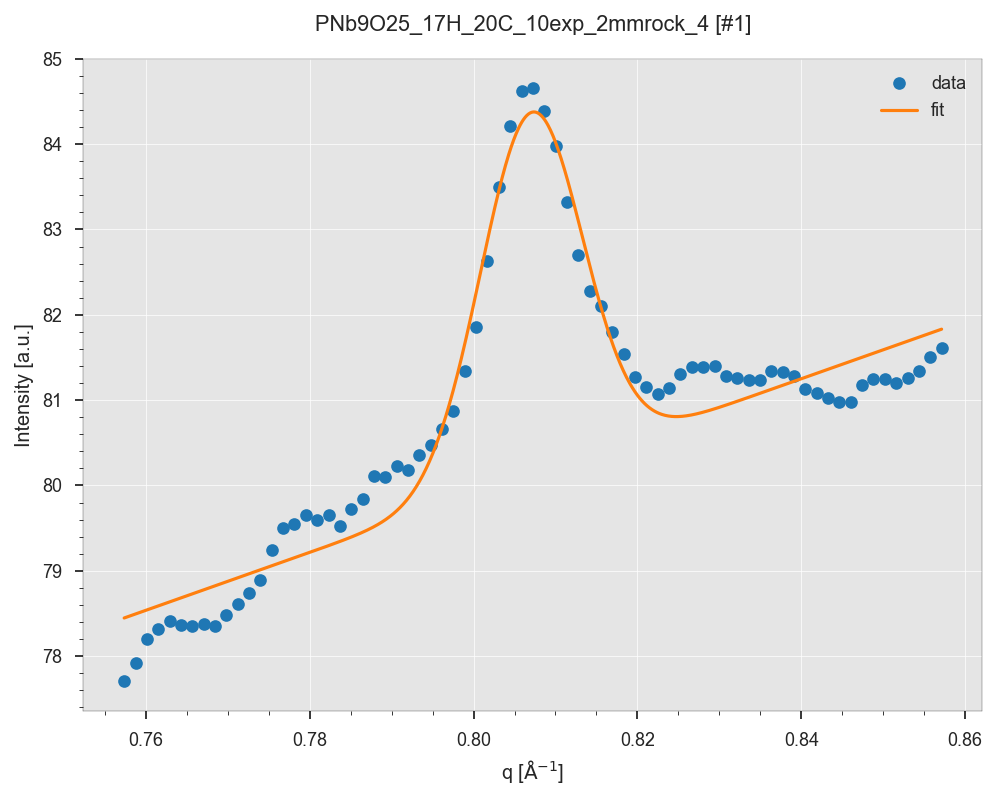

In [16]:
f4, f4_ax1 = plt.subplots(figsize=(10, 8))

fit_types = list(All_Fit_Data.keys())
Fits_Dict = All_Fit_Data[fit_types[-1]]
scans = [k for k, v in Fits_Dict.items() if len(v) > 0]
phases = list(Fit_Qs.keys())

phase_widget = Dropdown(options=phases)
n_widget = IntSlider(min=1, max=200, value=0, step=1)

n = len(Fits_Dict[scans[0]][phases[0]]['fitVals'][0])
@interact(fit_type=Dropdown(options=list(All_Fit_Data.keys()), value=fit_types[-1]),
          scan=Dropdown(options=scans, value=scans[0]),
          phase=phase_widget,
          n=n_widget,
          set_qRange=False, qRange=FloatRangeSlider(min=1.1, max=5.5, step=0.005, value=(2.54, 2.77)),
          show_comps=False, 
         )
def show_fit(fit_type, scan, phase, n, set_qRange, qRange, show_comps):
    f4_ax1.cla()
    
    Fits_Dict = All_Fit_Data[fit_type]

    # Reset Widget Options
    phase_widget.options = Fits_Dict[scan].keys()
    n_widget.max = len(Fits_Dict[scan][phase]['fitVals'][0])

    #q_c, ii_c = Fits_Dict[scan][phase]['cuts'][0][n-1], Fits_Dict[scan][phase]['cuts'][1][n-1]
    #inds = np.s_[:]
    #q, ii = q_c, ii_c
    if set_qRange:
        q, i_q = get_iq(df, idxs=[n-1], q_range=qRange, return_sum=True)
    else:
        q, i_q = Fits_Dict[scan][phase]['cuts'][0][n-1], Fits_Dict[scan][phase]['cuts'][1][n-1]
        #inds = ( (q >= qRange[0]) & (q <= qRange[1]) )
    #ax_f2.plot(q[n-1, inds], ii[n-1, inds], 'o', label='data')
    #ax_f2.plot(q[n-1, inds], ii[n-1, inds], 'o', label='data')
    f4_ax1.plot(q, i_q, 'o', label='data')

    q_f, y_f = Fits_Dict[scan][phase]['fitVals'][0][n-1], Fits_Dict[scan][phase]['fitVals'][1][n-1]
    #q_f = np.linspace(q_c.min(), q_c.max(), len(y_f))        
    #q_f = np.linspace(q.min(), q.max(), len(y_f))        
    f4_ax1.plot(q_f, y_f, '-', label='fit')

    if show_comps:
        comps = Fits_Dict[scan][phase]['fitComps'][n-1]
        for k, comp in comps.items():
            #f4_ax1.plot(q[inds], comp[inds], '--', label=k)
            f4_ax1.plot(q, comp, '--', label=k)

    f4_ax1.set_xlabel(rf'q [${AA}$]')
    f4_ax1.set_ylabel('Intensity [a.u.]')
    f4_ax1.set_title(f'{scan} [#{n}]', pad = 20)

    f4_ax1.legend()
    
    f4.tight_layout()

## Plot Fit Parameters 

interactive(children=(Dropdown(description='scan', options=('PNb9O25_17H_20C_10exp_2mmrock_4',), value='PNb9O2…

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
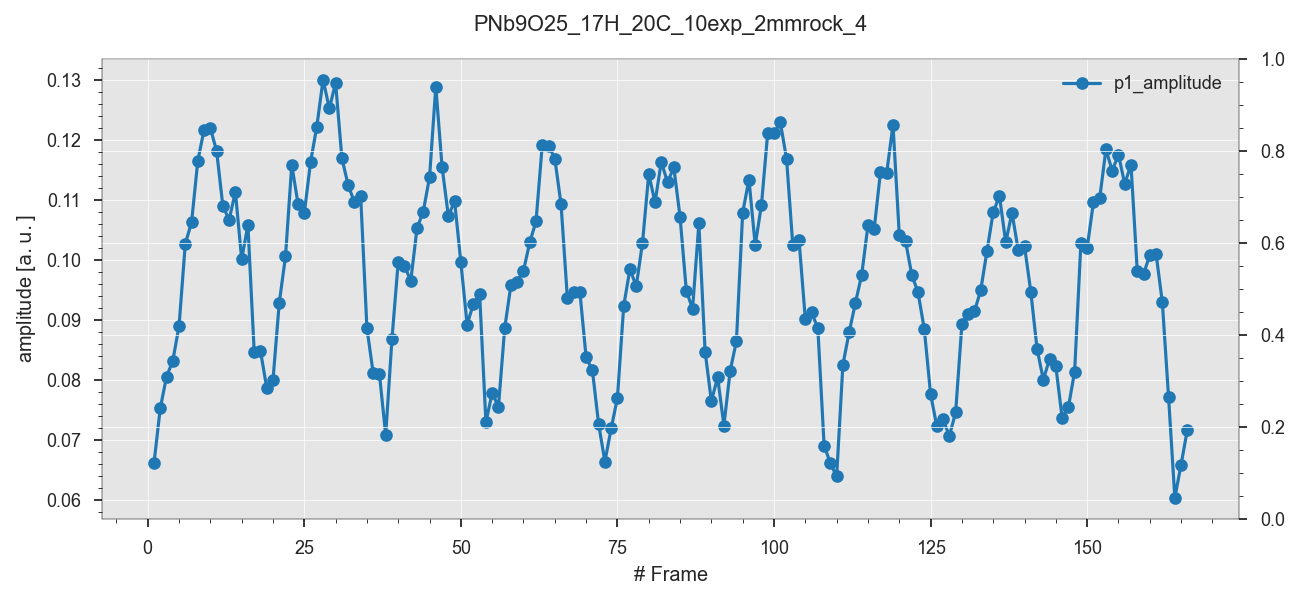

In [19]:
f3, ax_f3 = plt.subplots(figsize=(13, 6))
ax2_f3 = ax_f3.twinx()

fit_types = list(All_Fit_Data.keys())
Fits_Dict = All_Fit_Data[fit_types[-1]]

scans = [k for k, v in Fits_Dict.items() if len(v) > 0]
scan = scans[0]

phases = list(Fit_Data[scan].keys())
phase = phases[0]

fit_pars_all = list(Fit_Data[scan][phase]['allPVals'].keys())

phase_widget = Dropdown(options=phases)
fit_pars_widget = SelectMultiple(options=fit_pars_all, value=['p1_amplitude'])
sum_pars_widget = Checkbox(description='Sum Parameters')

units = dict(center=AA, sigma=AA)
Scan, Phase = None, None

X, Y = None, None

@interact(scan=Dropdown(options=scans, value=scans[0]),
          fit_type=Dropdown(options=list(All_Fit_Data.keys()), value=fit_types[-1]),
          phase=phase_widget, 
          fit_pars=fit_pars_widget,
          show_errors=False, sum_pars=sum_pars_widget
         )
def show_fit_par(scan, fit_type, phase, fit_pars, show_errors, sum_pars):
    [ax.cla() for ax in f3.get_axes()]
    
    global Scan, Phase, X, Y
    Fits_Dict = All_Fit_Data[fit_type]

    # Reset Widget Options
    phase_widget.options = Fits_Dict[scan].keys()
    fit_pars_widget.options = list(Fits_Dict[scan][phase]['allPVals'].keys())
        
    pval_sum, perr_sum, label_sum = 0, 0, []
    for fit_par in fit_pars:
        try:
            pval, perr = Fits_Dict[scan][phase]['allPVals'][fit_par]
        except KeyError:
            continue
                    
        perr[perr == None] = 0.0
        x = np.arange(1, len(pval)+1)
        # if x_par == 'Frame #':
        # else:
        #     x = df[x_par]
        
        X, Y = x, pval
        if not sum_pars:
            if show_errors:
                ax_f3.errorbar(x, pval, yerr=perr, fmt='o-', label=fit_par)
            else:
                ax_f3.plot(x, pval, 'o-', label=fit_par)
                                
                
        pval_sum += pval
        label_sum += [fit_par]
        
    if sum_pars:
        label_sum = '+'.join(label_sum)
        if show_errors:
            ax_f3.errorbar(x, pval_sum, yerr=perr_sum, fmt='o-', label=label_sum)
        else:
            ax_f3.plot(x, pval_sum, 'o-', label=label_sum)        

    ax_f3.set_xlabel(f'# Frame')
    
    # Get Y Axis Label
    y_unit = '\mathrm{a.u.}'
    pars = [p[3:] if (p[0] == 'p') and (p[2] == '_') else p for p in fit_pars]
    ylabel = pars[0] if len(set(pars)) == 1 else '' 
    if ylabel in units.keys():
        y_unit = f'{units[ylabel]}'
    ax_f3.set_ylabel(rf'{ylabel} [${y_unit}$]')

    ax_f3.set_title(f'{scan}', pad = 20)
    ax_f3.legend()
    
    Scan, Phase = scan, phase
    f3.tight_layout()

In [40]:
df['time/s']

1              NaN
2         9.291200
3        26.291199
4        42.291199
5        59.291199
          ...     
162    2658.462533
163    2677.166421
164            NaN
165            NaN
166            NaN
Name: time/s, Length: 166, dtype: float64

In [ ]:

@interact(
    x_col=Dropdown(value='time/s', options=df_echem.columns),
    y_col=Dropdown(value='Ewe/V', options=df_echem.columns),
    cycles=SelectMultiple(value=['all'], options=['all'] + n_cycles)
)
def plot_echem(x_col, y_col, cycles):
    f2_ax1.cla()
    
    if 'all' in cycles:
        x, y = df_echem[x_col], df_echem[y_col]
        f2_ax1.plot(x, y, 'o', ms=3, label='All')
    else:
        for cycle in cycles:
            x, y = df_echem[x_col][cycle_number==cycle], df_echem[y_col][cycle_number==cycle]
            f2_ax1.plot(x, y, 'o', ms=3, label=f'cycle #{cycle}')
    
    f2_ax1.set_xlabel(x_col)
    f2_ax1.set_ylabel(y_col)

# Get Spline
    y_spl = UnivariateSpline(x, y, s=0, k=4)
    x_range = np.linspace(x.iloc[0], x.iloc[-1], 1000)
    print(x.iloc[0], x.iloc[-1])
    #f2_ax1.plot(x_range, y_spl(x_range), label='Fit', color='r')

    # Get Derivative
    y_spl_1d = y_spl.derivative(n=1)
    #f2_ax1.plot(x_range, y_spl_1d(x_range), label='First Derivative', color='g')
    
    #f2_ax1.plot(x, np.gradient(np.gradient(y, x), x), 'o-', label='Derivative', color='r', ms=3, lw=0.5)

    f2_ax1.plot(x[1:], np.diff(y)*5, 'o-', label='Derivative', color='r', ms=3, lw=0.5)

    #plt.legend()